## FRC Team Analysis
#### By Draven Schilling, 10/18/19

The First Robotics competition is a high school level robotics competition where teams across the world are introduced to a new engineering challenge every year and are given 10 weeks to design, build, and test their robots; then in the following weeks are eligible to compete at local, district, and regional competitions. Finally, regional winners and special award winners are invited to attend the FRC championship to play against the best of the best and determine who the 'world champions' that year are.
At competitions teams play up to 5 qualification matches comprised of a "random" alliance selection for a total of ~80 qualification matches over the entire competition. Based on a team’s performance in their qualification matches teams are given a rank and after all of the qualification matches are finished the top 8 teams are allowed to pick their elimination round alliances. Alliance selection is performed in a serpentine manner until each alliance comprises of three teams. After alliance selection, a standard tournament bracket is setup and the alliances face off in rounds of best of three until a champion alliance is crowned.

A very important factor at competition is creating a winning alliance composition during the alliance creation before the elimination rounds and many picking teams neglect to pick a winning composition and instead tend to pick based on qualification rank. One goal of this report is to provide an alternative ranking in which to pick teams. Though primarily in this report I will be analyzing team performance over the years to identify if there are correlations between a team's historical data and their level of success. Specifically, we want to identify which particular features can be used to predict how successful a team is and potentially use those features to predict the most important features for successful teams in the future. 

The dataset I have acquired was created specifically for this purpose and was obtained by scraping “The Blue Alliance API”. The Blue Alliance is the largest mainstream resource for storing FIRST competition data for both teams and match results year to year. From the API I was able to obtain regional, district, and championship data for all the available teams and events each year. The data set contains the following:

team - Distinct Team identifier key
avg_ccwm - Interpreted statistic for average "Calculated Contribution to Winning Margin" over all attended competitions
avg_dpr - Interpreted statistic for average "Defensive Power Rating" over all attended competitions
avg_opr - Interpreted statistic for average "Offensive Power Rating" over all attended competitions
avg_rank - Average ending qualification rank over all competitions attended
blue_banners - Number of competition wins (dependent variable)
champ_wins - Number of world championship wins
competitions_attended - Total number of regional/district competitions attended
match_win_rate - average win rate per competition as wins/total matches played
postal_code - zip code for the team's headquarters
rookie_year - year of the team’s first appearance
state_prov - state or province where the team is located
total_awards - total number of awards defined as wins + other regional awards (Engineering design, Innov in controls, etc...)
years_attended - total number of years the team was registered and active at at least 1 competition

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

First we will import the required libraries, followed by the data and preview the head to ensure it was loaded correctly and see what we have to work with.

In [2]:
tba_df = pd.read_json("tba-data-formatted.txt")
tba_df.head()

avg_ccwm    avg_dpr    avg_opr   avg_rank  blue_banners  champ_wins  \
0 -16.725194  38.230143  13.122634  27.400000             3           0   
1   5.403544  26.751173  31.567034  31.972222             2           0   
2 -15.855096  27.684755   0.127998  31.750000             2           0   
3   0.000000   0.000000   0.000000   0.000000             0           0   
4 -13.311528   8.056996  -8.128481  31.333333             1           0   

   competitions_attended  match_win_rate  num_match_losses  num_match_wins  \
0                     35        0.471186               148             139   
1                     36        0.436242               160             130   
2                      4        0.357143                26              15   
3                      0        0.000000                 0               0   
4                      6        0.450000                20              18   

  postal_code  rookie_year  state_prov  team  total_awards  \
0       48340       1997.0    Michigan  frc1            36   
1       91406       1997.0  California  frc4            10   
2        None       1998.0          MI  frc5            10   
3        None       1994.0          MN  frc6             1   
4        None          NaN          MD  frc7             8   

   total_matches_played  years_attended  
0                   295              24  
1                   298              15  
2                    42              12  
3                     0              10  
4                    40              16

In [3]:
tba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 17 columns):
avg_ccwm                 7293 non-null float64
avg_dpr                  7293 non-null float64
avg_opr                  7293 non-null float64
avg_rank                 7293 non-null float64
blue_banners             7293 non-null int64
champ_wins               7293 non-null int64
competitions_attended    7293 non-null int64
match_win_rate           7293 non-null float64
num_match_losses         7293 non-null int64
num_match_wins           7293 non-null int64
postal_code              5063 non-null object
rookie_year              6951 non-null float64
state_prov               7248 non-null object
team                     7293 non-null object
total_awards             7293 non-null int64
total_matches_played     7293 non-null int64
years_attended           7293 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 968.7+ KB


### Hypothesizes (EDA)
Some initial hypothesizes I get before exploring the data are the following:

1. offensive power rating has to be more valuable then defensive power rating
2. generally older teams must be better
3. There must be locational hotspots of good teams
4. Higher Ranked teams must win more often
5. teams that won a championship must be generally better teams

We may not be able to formally test all of these hypothesizes but from visualization we may be able to notice trends that either support or deny these acquisitions. 

One thing we may have problem with is not providing a fair basis for a win metric. Teams that have existed for longer will have more opportunities to win compared to newer teams, so maybe a better metric to compare against is competition_win_rate. Let’s first create that feature.

In [4]:
def avg_blue_banners(blue_banners, competitions_attended):
    if competitions_attended != 0:
        return blue_banners / competitions_attended
    else:
        return 0
    
tba_df['competition_win_rate'] = tba_df.apply(lambda s: avg_blue_banners(s.blue_banners, s.competitions_attended), axis=1)
tba_df.head()

avg_ccwm    avg_dpr    avg_opr   avg_rank  blue_banners  champ_wins  \
0 -16.725194  38.230143  13.122634  27.400000             3           0   
1   5.403544  26.751173  31.567034  31.972222             2           0   
2 -15.855096  27.684755   0.127998  31.750000             2           0   
3   0.000000   0.000000   0.000000   0.000000             0           0   
4 -13.311528   8.056996  -8.128481  31.333333             1           0   

   competitions_attended  match_win_rate  num_match_losses  num_match_wins  \
0                     35        0.471186               148             139   
1                     36        0.436242               160             130   
2                      4        0.357143                26              15   
3                      0        0.000000                 0               0   
4                      6        0.450000                20              18   

  postal_code  rookie_year  state_prov  team  total_awards  \
0       48340       1997.0    Michigan  frc1            36   
1       91406       1997.0  California  frc4            10   
2        None       1998.0          MI  frc5            10   
3        None       1994.0          MN  frc6             1   
4        None          NaN          MD  frc7             8   

   total_matches_played  years_attended  competition_win_rate  
0                   295              24              0.085714  
1                   298              15              0.055556  
2                    42              12              0.500000  
3                     0              10              0.000000  
4                    40              16              0.166667

### Data Visualization
Let’s Now start to plot some of these independent variables starting with average qualification rank and see how they are associated with the winning statistics.

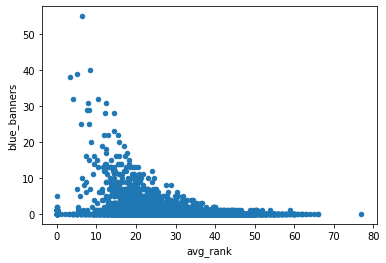

In [5]:
tba_df.plot(x = "avg_rank", y = "blue_banners", kind="scatter")

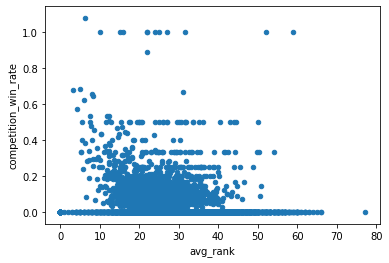

In [6]:
tba_df.plot(x = "avg_rank", y = "competition_win_rate", kind="scatter")

My prediction was that rank would be very strongly correlated with the number of wins, since typically higher ranked teams perform better and often either the first or second ranked team will have the highest chance of winning a regional. 
This generally seems to trend true, but what's interesting is how much more variance the competition win rate has compared to just the total number of wins. Initially, I thought creating a win rate statistic will give newer teams more of an equal playing field but looking at this data it may have provided almost the opposite effect. 
A new hypothesis I may now have is what is the spread of the number of competitions teams attend? Because I now realize a side effect of competition win rate is that it will superficially boost some teams that have only been to a handful of competitions and may have gotten lucky and won one.


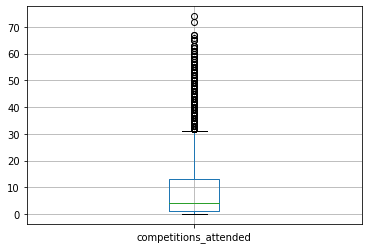

In [7]:
tba_df.boxplot(column = "competitions_attended")

Just as I would suspect, majority of teams seem to have attended only a handful of events which would superficially boost this rate. In order to produce the best predictions, I feel using just total number of blue banners will give us the best results.

Let’s look at some of the Blue Alliance API interpreted statistics next.

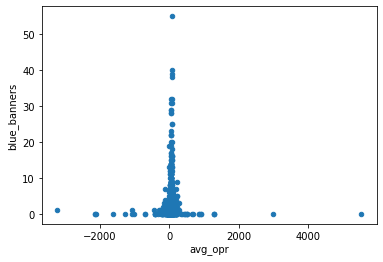

In [8]:
tba_df.plot(x = "avg_opr", y = "blue_banners", kind="scatter")

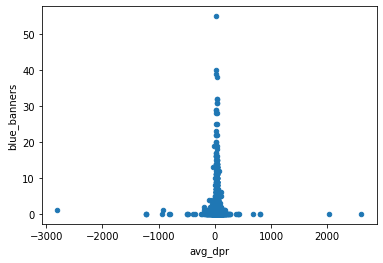

In [9]:
tba_df.plot(x = "avg_dpr", y = "blue_banners", kind="scatter")

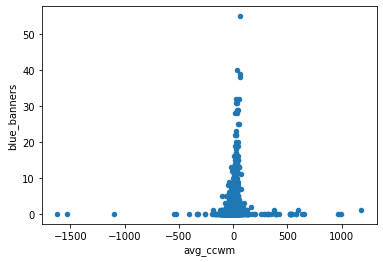

In [10]:
tba_df.plot(x = "avg_ccwm", y = "blue_banners", kind="scatter")

These statistics are also very interesting because they seem to all be normalized around 0, but teams that consistently do better in these margins do not necessarily have more wins. Either the calculations for these numbers have changed over the years and that differences may mean different things, or these statistics are actually not that great predictors of a team’s performance. Either way, we learned that when looking at a high level of these interpreted stats their meaning and relation to performance is completely lost. Therefore, my initial predictions which suggested these stats be good predictors of a team’s performance was wrong, and what’s more, no which one of these (opr, drp, and ccwm) is much better of a predictor than the others.

Next, let’s look at match_win_rate.

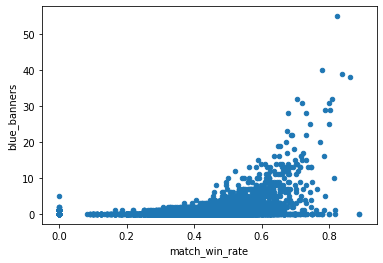

In [11]:
tba_df.plot(x = "match_win_rate", y = "blue_banners", kind="scatter")

This is another easy one since there is clearly a correlation between individual match win rate and competition win rate just as you would expect.
Let's look at if a team's rookie year influences their wins next.

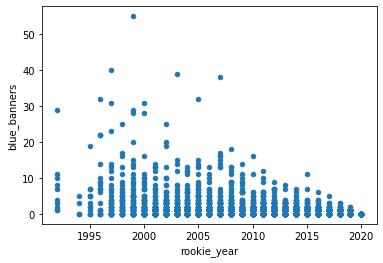

In [12]:
tba_df.plot(x = "rookie_year", y = "blue_banners", kind="scatter")

What I would expect to see based on my predictions was that older teams generally have more wins than newer teams (since they would have more opportunities and wisdom to win). It does seem clear that the current most successful teams (15+ wins) were mostly from the earlier days (pre-2010), though for the majority of the teams, the correlation is actually not that great.
Since the rookie year doesn't tell us exactly how active a team is, maybe most of the older teams no longer compete and therefore are no longer given a chance to win? Maybe a better statistic to look at would be years_attended.

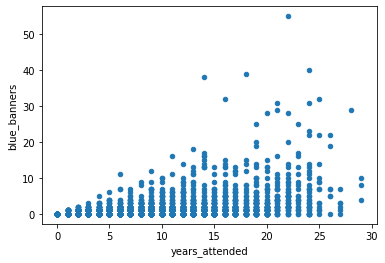

In [13]:
tba_df.plot(x = "years_attended", y = "blue_banners", kind="scatter")

Just as I hypothesized, years_attended looks a little bit better than rookie_year and provides us with similar information. Though the correlation is still much weaker than some of the other statistics we looked at.  Finally, let’s look at total number of awards and number of championship wins.

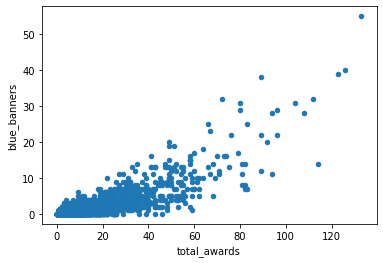

In [14]:
tba_df.plot(x = "total_awards", y = "blue_banners", kind="scatter")

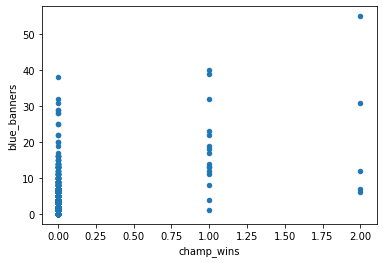

In [15]:
tba_df.plot(x = "champ_wins", y = "blue_banners", kind="scatter")

having more total awards definitely correlates with number of blue banners just as you would expect. This is likely due to some bleed over from blue banners counting as "awards", but also I think it's fair to suggest that teams winning robot awards likely also have a strong robot that it competing well as it is common for champions to also win unrelated awards at the same competition.
As for championship wins, I would have expected a stronger correlation. I feel like any team which has won a championship, more of less multiple championships would have the funding to continue to produce winning robots. Unfortunately, it seems as if this may not be true, or at least the pool of championship winning teams is so small that the sample size of teams winning one/two championships isn’t big enough to suggest a strong correlation.

Last but not least, let’s look at locational data such as state/prov and postal code.

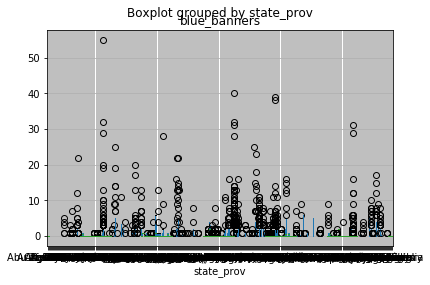

In [16]:
tba_df.boxplot(by = "state_prov", column = "blue_banners")

Unfortunately, postal code produced too many categories to load so I was not able to display that chart. But from state/prov we can clearly see some defined pockets where there are successful teams. The x-axis is so cluttered that it is hard to identify the specific regions but there is for sure some indication that maybe some states are just filled with more successful teams.

Overall, from our EDA what have we learned?
-TBA interpreted statistics are not great predictors at the high level
-Total number of blue banners are going to be a better predictor (in our case) than average win rate
-Rank and match win rate is strongly correlated with number of wins as we would expect. This supports the traditional pick list model based on rank.
-How old a team is does not always make them better. Though only older teams are the most successful.
-There may be regions of particularly successful teams, though further investigation is needed.

### Data Pre-Processing
Before progressing with ML methods, the first thing we may want to do is standardize all of the data and get rid of any Null row entries. We may also want to convert types to categorical where applicable. We start by categorizing state_prov, postal_code, and rookie_year because the years themselves have no relation between one another.

Looking at the columns which need imputation, we can clearly see they are all categorical (state_prov, rookie_year, and postal_code). One approach for categorical variables would be to take the mode though in this scenario I feel it best to leave those NaN values as Unknown categories.

In [17]:
tba_df.state_prov = tba_df.state_prov.astype("category")
tba_df.rookie_year = tba_df.rookie_year.astype("category")
tba_df.postal_code = tba_df.postal_code.astype("category")
tba_df['state_prov'] = tba_df['state_prov'].cat.add_categories('Unknown')
tba_df['state_prov'].fillna('Unknown', inplace =True)
tba_df['postal_code'] = tba_df['postal_code'].cat.add_categories('Unknown')
tba_df['postal_code'].fillna('Unknown', inplace =True)
tba_df['rookie_year'] = tba_df['rookie_year'].cat.add_categories('Unknown')
tba_df['rookie_year'].fillna('Unknown', inplace =True)

tba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 18 columns):
avg_ccwm                 7293 non-null float64
avg_dpr                  7293 non-null float64
avg_opr                  7293 non-null float64
avg_rank                 7293 non-null float64
blue_banners             7293 non-null int64
champ_wins               7293 non-null int64
competitions_attended    7293 non-null int64
match_win_rate           7293 non-null float64
num_match_losses         7293 non-null int64
num_match_wins           7293 non-null int64
postal_code              7293 non-null category
rookie_year              7293 non-null category
state_prov               7293 non-null category
team                     7293 non-null object
total_awards             7293 non-null int64
total_matches_played     7293 non-null int64
years_attended           7293 non-null int64
competition_win_rate     7293 non-null float64
dtypes: category(3), float64(6), int64(8), object(1)
memory u

Now we can see all of the data is clean and ready to be processed.
Let’s create dummy variables using one hot encoding for our categorical variables and split test/train our data to prepare for ML methods.

In [18]:
all_columns = ['avg_ccwm', 'avg_dpr', 'avg_opr', 'avg_rank', 'champ_wins', 'competitions_attended',
               'match_win_rate', 'rookie_year', 'state_prov', 'total_awards',
               'total_matches_played', 'years_attended']
categorical_columns = ['postal_code', 'rookie_year', 'state_prov']
dummy_columns = {}

for dummy_column in categorical_columns:
    dummies = pd.get_dummies(tba_df[dummy_column], prefix=dummy_column)
    dummy_columns[dummy_column] = dummies.columns.values
    tba_df = tba_df.merge(dummies, left_index=True, right_index=True)
    tba_df = tba_df.drop(columns=dummy_column)
    
df_train, df_test = train_test_split(tba_df)
print(tba_df.shape[0], df_train.shape[0], df_test.shape[0])

7293 5469 1824


### Data Modeling 

The goals for examining this data is to classify what metrics define a "good teams" and ultimately quantify those metrics to create a predictive model that can determine a team's "winning" potential as number of historical wins. To use as our "winning" metric, the number of blue banners a team owns tells us exactly how many competitions they won.

My prediction based on the EDA is that awards, win_rate, and rank would be the most influential while all of the other stats would only hinder the model. 

For our test, we will be first creating a null model and comparing it against a greedy algorithm which will determine the best predictive powers and use those as metrics for regression. We will analyze which features the greedy method uses and compare those with our predicted features and finally, we will compare our greedy model with the null and see how it fairs.

First, let’s start with the null model.

Base Model MSE: 6.261877007749079
Base Model RMSE: 2.502374274114302


Text(0, 0.5, 'Predicted num blue banners')

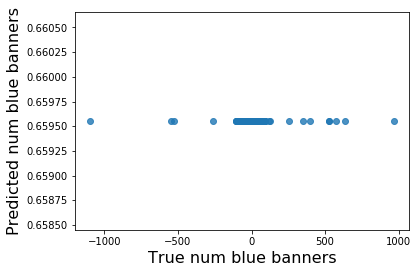

In [19]:
y_train = df_train["blue_banners"].values
y_test = df_test["blue_banners"].values

zeros_train = np.zeros(df_train[["avg_ccwm"]].astype("float64").values.shape)
zeros_test = np.zeros(df_test[["avg_ccwm"]].astype("float64").values.shape)
base_lr = SGDRegressor(max_iter=5000)
base_lr.fit(zeros_train, y_train)

null_predict_test = base_lr.predict(zeros_test)

base_mse = mean_squared_error(y_test, null_predict_test)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

sns.regplot(x=df_test["avg_ccwm"].values, y=null_predict_test, fit_reg=False)
plt.xlabel("True num blue banners", fontsize=16)
plt.ylabel("Predicted num blue banners", fontsize=16)

With the null model created, let's now import the methods for our greedy model.

In [20]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns=None):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    if dummy_columns is None:
        dummy_columns = dict()
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        #imputer = Imputer(missing_values=0)
        #X_train_numerical = imputer.fit_transform(X_train_numerical)
        #X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [21]:
def sort_columns(df_train, df_test, y_train, y_test, all_columns, dummy_columns=None):
    column_rmses = []

    for col_name in all_columns:
        X_train, X_test = create_feature_matrices(df_train,
                                                 df_test,
                                                 [col_name],
                                                 dummy_columns=dummy_columns)
    
        simple_lr = SGDRegressor(max_iter=5000)
        simple_lr.fit(X_train, y_train)
        pred_prices_simple_test = simple_lr.predict(X_test)
        simple_mse = mean_squared_error(y_test, pred_prices_simple_test)
        simple_rmse = np.sqrt(simple_mse)
        print()
        print(col_name + " Model MSE:", simple_mse)
        print(col_name + " Model RMSE:", simple_rmse)
        column_rmses.append((simple_rmse, col_name))
    
    column_rmses.sort(key=lambda p: p[0])
    sorted_columns = [col_name for _, col_name in column_rmses]
    print()
    print("Sorted columns:" + str(sorted_columns))
    
    return sorted_columns

In [22]:
def select_features(df_train, df_test, y_train, y_test, sorted_columns, dummy_columns=None):
    lr = SGDRegressor(max_iter=5000)
    
    train_zeros = np.zeros((y_train.shape[0], 1))
    test_zeros = np.zeros((y_test.shape[0], 1))
    lr.fit(train_zeros, y_train)
    pred_y_test = lr.predict(test_zeros)
    
    null_mse = mean_squared_error(y_test, pred_y_test)
    null_rmse = np.sqrt(null_mse)
    
    base_model_columns = []
    base_rmse = null_rmse
    base_mse = null_mse

    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()

    for col_name in sorted_columns:
        # track all column names
        trial_columns = base_model_columns[:]
        trial_columns.append(col_name)

        X_train, X_test = create_feature_matrices(df_train,
                                                  df_test,
                                                  trial_columns,
                                                  dummy_columns=dummy_columns)
    
        lr = SGDRegressor(max_iter=5000)
        lr.fit(X_train, y_train)
        pred_y_test = lr.predict(X_test)
        trial_mse = mean_squared_error(y_test, pred_y_test)
        trial_rmse = np.sqrt(trial_mse)
        print()
        print(str(trial_columns) + " Model MSE:", trial_mse)
        print(str(trial_columns) + " Model RMSE:", trial_rmse)
    
        if trial_rmse < base_rmse:
            print("Updating base model")
            base_rmse = trial_rmse
            base_mse = trial_mse
            base_model_columns = trial_columns
        
        print()
        print("Base Model MSE:", base_mse)
        print("Base Model RMSE:", base_rmse)
        print()
    
    print("Our chosen columns are: " + str(base_model_columns))
    return base_model_columns

Let's now perform the greedy algorithm by first sorting the predictive power of all the variables.

In [23]:
sorted_columns = sort_columns(df_train, df_test, y_train, y_test, all_columns, dummy_columns=dummy_columns)


avg_ccwm Model MSE: 6.224826060606319
avg_ccwm Model RMSE: 2.4949601320675083

avg_dpr Model MSE: 6.266548681228563
avg_dpr Model RMSE: 2.5033075482706

avg_opr Model MSE: 6.280856817775053
avg_opr Model RMSE: 2.5061637651548336

avg_rank Model MSE: 6.222331817477946
avg_rank Model RMSE: 2.4944602256756765

champ_wins Model MSE: 4.404162050007135
champ_wins Model RMSE: 2.098609551585796

competitions_attended Model MSE: 3.9074980818744387
competitions_attended Model RMSE: 1.9767392549029927

match_win_rate Model MSE: 5.641192032578851
match_win_rate Model RMSE: 2.3751193722798125

rookie_year Model MSE: 5.440748986741817
rookie_year Model RMSE: 2.3325413151200167

state_prov Model MSE: 6.0936416956229476
state_prov Model RMSE: 2.468530270347712

total_awards Model MSE: 1.7629533457979163
total_awards Model RMSE: 1.3277625336625207

total_matches_played Model MSE: 4.008883778209973
total_matches_played Model RMSE: 2.0022197127712964

years_attended Model MSE: 4.951161884642722
years_at

Next, let's select which features will acutally increase the predictive power of the model.

In [24]:
selected_columns = select_features(df_train, df_test, y_train, y_test, sorted_columns, dummy_columns=dummy_columns)

Base Model MSE: 6.26699212394096
Base Model RMSE: 2.50339611806461


['total_awards'] Model MSE: 1.7368678574386531
['total_awards'] Model RMSE: 1.3179028254915661
Updating base model

Base Model MSE: 1.7368678574386531
Base Model RMSE: 1.3179028254915661


['total_awards', 'competitions_attended'] Model MSE: 1.6497158388600954
['total_awards', 'competitions_attended'] Model RMSE: 1.284412643530145
Updating base model

Base Model MSE: 1.6497158388600954
Base Model RMSE: 1.284412643530145


['total_awards', 'competitions_attended', 'total_matches_played'] Model MSE: 1.653350893356101
['total_awards', 'competitions_attended', 'total_matches_played'] Model RMSE: 1.2858269297833598

Base Model MSE: 1.6497158388600954
Base Model RMSE: 1.284412643530145


['total_awards', 'competitions_attended', 'champ_wins'] Model MSE: 1.3692546535088541
['total_awards', 'competitions_attended', 'champ_wins'] Model RMSE: 1.1701515515132448
Updating base model

Base Model MSE: 1.3692546535088541
Base Model 


Model MSE: 1.3763244230750629
Model RMSE: 1.1731685399272616


Text(0, 0.5, 'Predicted wins')

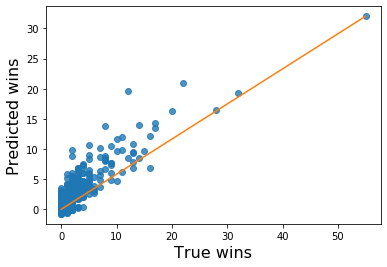

In [26]:
X_train, X_test = create_feature_matrices(df_train, df_test, selected_columns, dummy_columns=dummy_columns)

lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_prices_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_prices_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)

sns.regplot(x=y_test, y=pred_prices_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_test)])
plt.xlabel("True wins", fontsize=16)
plt.ylabel("Predicted wins", fontsize=16)

First, let’s compare the null model with the predictive model. The null model had an RMSE of 2.5 compared to the predictive model of 1.17 which is just over a 50% improvement.
More than anything, we are most interested in which features the greedy algorithm identified as most predictive. (total_awards, competitions_attended, champ_wins, years_attended, and match_win_rate. Based on that fact, it seems like the greedy algorithm pulled features from across the board and not just wins and awards which is very interesting. I guess in order to be a winning team you need a combination of years of experience, have a history of other success measures, and continuously build high ranking robots.

### Additional Results \ Analysis
My hypothesizes were answered though EDA and the predictive power of each feature was further analyzed though the regression model.

Did I miss anything in my analysis?
Obviously, there is plenty of room for growth. Just in my data acquisition, I feel that my data set is still far from perfect. It's missing a lot of locational data and the validity of much of the team data is entered by team members so it may be outdated or inconsistent.
For analysis, I would have loved to create a better metric to gauge success rather than just flat out wins and/or win rate. I also wish I could have created a ranker which allows you to input teams and gives you a ranked output of the ML model predictions for each team in order of their success measure. I would have also liked to compare those rank predictions with actual ranks and see how they fair in determining what the alliance compositions were. There is plenty left to continue the project.
